## Credit Card Fraud Detection - Alan Castillo

The credit card dataset is from Kaggle,

https://www.kaggle.com/mlg-ulb/creditcardfraud

The Algorithms and there parameters are described in the links below,

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

#### Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The data  contains only numerical input variables which are the result of a Principal Component Analysis (PCA) transformation. PCA is useful since the dimensions of the features were dealing with are high. We are basically compressing the data and removing noise. However, there are two drawbacks from the dataset we are given. One, we dont know how much of the data was compressed. PCA works by taking taking the two dimensions that explains the highest amount of variability in the data. We are not told whether the PCA explains 90% of the variability in the data or 10%. Two, Unfortunately, due to confidentiality issues, the dataset does not provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [114]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [115]:
data = pd.read_csv('creditcard.csv', sep=',')
data.head() 
#class == 0 means not fraud, class == 1, means fraud
#Time is the number of seconds elasped between the current transaction and the first transaction in the dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Cleaning

In [116]:
data.isnull().values.any() #no null data, no need to clean

False

### Exploratory Data Analysis

##### 1) What is the average amount on each transaction for Europeans in the two days that the dataset covers?

In [117]:
data["Amount"].mean()

88.34961925087359

That is 88 Euros per transaction in 2013, which with inflation is 94 Euros today. Which 112.967 USD per transaction. 
That's quite a lot of money per transaction. However, this average could be affected by larger much larger transactions to pay off mortgages or purchase other big tickets. Lets describe the data and see what we learn.

In [118]:
data["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

So this clears up the picture. The variance between transactions is very large, which is given by the standard deviation of 250 Euros. We also see that 75% of all the transactions are at most 77.165 Euros. My hypothesis that the larger big ticket items definitely skewed the average, as we see the median lies somewhere around 22.

#### 2) Is there a noticeable difference between the Normal and Fraudulent transaction descriptions?

Text(0, 0.5, 'Frequency')

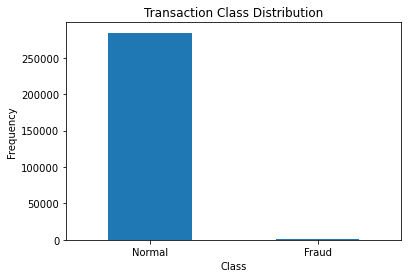

In [119]:
Labels = ["Normal", "Fraud"]
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), Labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

Note: Here we obviously see that the dataset is very unbalanced which is was given in the documentation that 0.172% of all the 284,000 transactions are fradulent.

In [120]:
fraudData = data[data["Class"]==1]
normalData = data[data["Class"]==0]

In [121]:
fraudData["Amount"].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [122]:
normalData["Amount"].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Here we see that the average amount per fradulent transactions is roughly 34 Euros larger than the average for normal transactions. The variance is roughly the same. Its also interesting to note that the max of the fraudulent transactions is smaller than that of the normal transaction, however we need to keep in mind that only a very small fraction of transaction are fraudulent so this may not be very representative. Also I notice that 50% of the fraudulent transactions are at most 9.25 which is much smaller than the 50% of normal transactions are at most 22. However once we get to the 3rd quartile (75%) we notice that the fraudulent transaction increase sharply to atmost 105.89 Euros while the normal transactions reach atmost 77 Euros for the 3rd quartile. 

## ML Prediction Model
The prediction models that we are going to use are based on anomaly detection. We will use the Isolation Forest algorithm and the Local Outlier Factor (LOF) algorithm. We are only going to run it on a sample of the data 
### Isolation Forest
The Isolation Forest algorithm is a tree-based unsupervised machine learning algorithm that can efficiently isolate outliers. The algorithm was first published in 2012 and then incorporated into the Python Scikit-Learn library. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.
### Local Outlier Factor (LOF)
LOF is an unsupervised machine learning algorithm, proposed in 2000, which produces an anomaly score that represents data points which are outliers in the data set. It does this by measuring the local density deviation of a given data point with respect to the data points near it. 

In [123]:
#Running the algorithms on the entire dataset would be very computationally expensive so we will just 
#use a sample to apply the algorithm

sampleData = data.sample(frac = 0.1, random_state=1)
sampleData.shape

(28481, 31)

In [124]:
#next we need to determine the contamination fraction, the proportion of outliers
contFraction = len(sampleData[sampleData["Class"]==1])/len(sampleData[sampleData["Class"]==0])
print(contFraction)

0.0017234102419808666


In [125]:
#Create independent and dependent features
columns = sampleData.columns.tolist()

In [126]:
#Here were getting all the columns but not the Class column
columns = [c for c in columns if c not in ["Class"]]

In [127]:
X = sampleData[columns] #Independent Data
Y = sampleData["Class"] #Dependent Data

## Model with contamination = contFraction

In [130]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=contFraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=contFraction)
}

In [131]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    print("Outliers Found in", clf_name + ":", n_errors)
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))

Outliers Found in Isolation Forest: 77
Accuracy Score :
0.9972964432428637
Outliers Found in Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425


## Model with contamination = "auto"

In [128]:
state = np.random.RandomState(42) 

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination="auto",random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination="auto")
}

In [129]:
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    print("Outliers Found in", clf_name + ":", n_errors)
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))

Outliers Found in Isolation Forest: 130
Accuracy Score :
0.9954355535269127
Outliers Found in Local Outlier Factor: 3251
Accuracy Score :
0.8858537270461009


### Conclusion

Both the ML algorithms are very accurate in determining outliers. We check what happens as we change the contamination parameter. The contamination parameter simply controls the threshold for the decision function when a scored data point should be considered an outlier. It has no impact on the model itself. This is important because in our last model, we set the contamination = contFraction, which was the proportion of outliers we know exists in the data. We see that by knowing the proportion we are able to get very accurate results with both Isolation Forest and LOF having >99% accuracy. 
However, I question how well this would work in the real world when we don't know the proportion of outliers. Thats why I checked how well the model would work if we didn't know the proportion of outliers. We see that the Isolation Forest still has >99% accuracy, but also finds 53 more outliers. More interestingly we see the accuracy of LOF faill to >88% and has found 3251 outliers, which implies that roughly 11% of all the sample transactions were outliers, which is very unlikely. 
So in conclusion I would go with the Isolation Forest Algorithm to determine Fraud.